In [71]:
import networkx as nx
import numpy as np
import torch
from model import CaT
import inference
import pandas as pd
import matplotlib.pyplot as plt
from datasets import get_full_ordering, reorder_dag
import utils

shuffling = 0
seed = 1
standardize = 0
sample_size = 100000
batch_size = 100
max_iters = 100000
eval_interval = 100
eval_iters = 100
validation_fraction = 0.3
np.random.seed(seed=seed)
torch.manual_seed(seed)
device = 'cuda'
dropout_rate = 0.0
learning_rate = 5e-3
ff_n_embed = 6
num_heads = 2
n_layers = 2
head_size = 6
d = 1

def generate_data(N, d=3):
    DAGnx = nx.DiGraph()
    
    Ux = np.random.randn(N,d)
    X =  Ux
    
    Ub = np.random.randn(N,d)
    B =  Ub
    
    Uc = np.random.randn(N,d)
    C =  Uc
    
    Uy = np.random.randn(N,d)
    Y = 0.3 * X + 0.6 * B + 1.2 * C +  Uy

    Y0 = 0.3 * 0 + 0.6 * B + 1.2 * C +  Uy
    Y1 =  0.3 * 1 + 0.6 * B + 1.2 * C + Uy

    all_data_dict = {'X': X, 'B': B, 'C': C, 'Y': Y}

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'X': 'cont', 'B': 'cont', 'C': 'cont', 'Y': 'cont'}

    DAGnx.add_edges_from([('X', 'Y'), ('B', 'Y'), ('C', 'Y')])
    DAGnx = reorder_dag(dag=DAGnx)  # topologically sorted dag
    var_names = list(DAGnx.nodes())  # topologically ordered list of variables
    all_data = np.stack([all_data_dict[key] for key in var_names], axis=1)
    causal_ordering = get_full_ordering(DAGnx)
    ordered_var_types = dict(sorted(var_types.items(), key=lambda item: causal_ordering[item[0]]))

    return all_data, DAGnx, var_names, causal_ordering, ordered_var_types, Y0, Y1




## Exogenous Example

In [66]:
def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

_, _, _, _, _, Y0, Y1 = generate_data(N=1000000, d=d)
ATE = (Y1 - Y0).mean(0)  # multi-dim ATE based off a large sample

print(ATE)


for i in range(1):
    all_data, DAGnx, var_names, causal_ordering, var_types, Y0, Y1 = generate_data(N=sample_size, d=d)
    indices = np.arange(0, len(all_data))
    np.random.shuffle(indices)
    
    val_inds = indices[:int(validation_fraction*len(indices))]
    train_inds = indices[int(validation_fraction*len(indices)):]
    train_data = all_data[train_inds]
    val_data = all_data[val_inds]
    train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()
    input_dim = all_data.shape[2]
    
    model = CaT(input_dim=input_dim,
                    dropout_rate=dropout_rate,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_n_embed=ff_n_embed,
                    dag=DAGnx,
                    causal_ordering=causal_ordering,
                    n_layers=n_layers,
                    device=device,
                    var_types=var_types,
                    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    all_var_losses = {}
    for iter_ in range(0, max_iters):
        # train and update the model
        model.train()
    
        xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
        xb_mod = torch.clone(xb.detach())
        X, loss, loss_dict = model(X=xb, targets=xb_mod, shuffling=shuffling)
    
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    
    
        if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
            for key in loss_dict.keys():
                if key not in all_var_losses.keys():
                    all_var_losses[key] = []
                all_var_losses[key].append(loss_dict[key])
    
            model.eval()
            eval_loss = {}
            for split in ['train', 'val']:
                losses = torch.zeros(eval_iters)
                for k in range(eval_iters):
    
                    xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                                   batch_size=batch_size)
                    xb_mod = torch.clone(xb.detach())
                    X, loss, loss_dict = model(X=xb, targets=xb_mod, shuffling=False)
                    losses[k] = loss.item()
                eval_loss[split] = losses.mean()
            model.train()
            # print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")

    model.eval()
    intervention_nodes_vals_0 = {'X': 0}
    intervention_nodes_vals_1 = {'X': 1}
    D0 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_0)
    D1 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_1)
    
    est_ATE = (D1[:,effect_index] - D0[:,effect_index]).mean()
    print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)
    


[0.3]
ATE: [0.3] est ATE: [0.07790562] error: [0.22209438]


ATE: [0.3] est ATE: [[0.07790562]] error: [[0.22209438]]


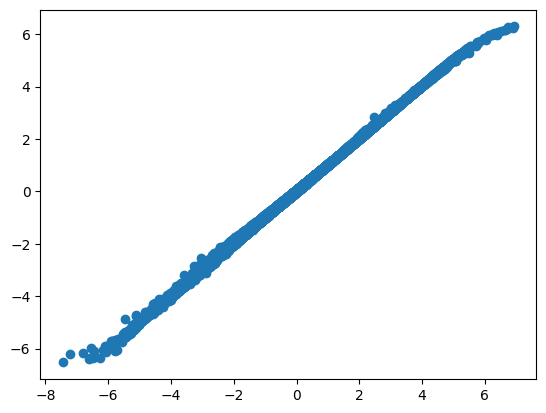

In [84]:
model.eval()
intervention_nodes_vals_0 = {'X': 0}
intervention_nodes_vals_1 = {'X': 1}
D0 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_0)
D1 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_1)

est_ATE = (D1[:,effect_index] - D0[:,effect_index]).mean(0)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)
preds = model(train_data.to(device))

plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())

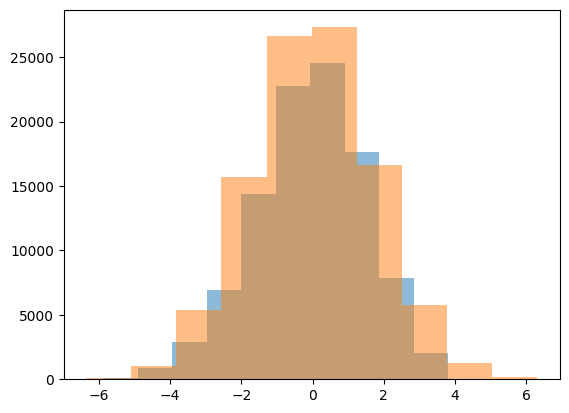

In [75]:

plt.hist(D0[:,3, 0], alpha=0.5)
plt.hist(D1[:,3, 0], alpha=0.5)
plt.show()

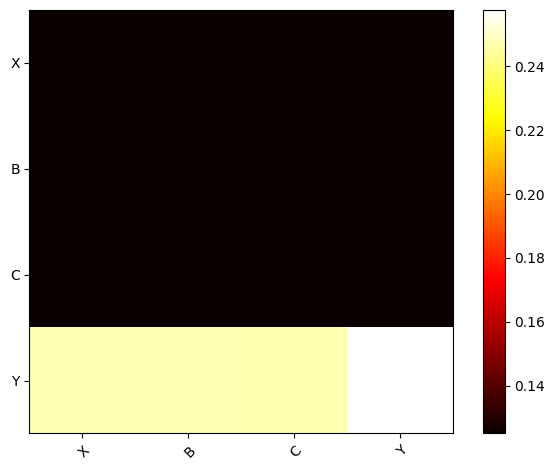

In [33]:
# view attention maps
maps = []
for j in range(n_layers):
    heads = model.blocks[j].mha.heads
    for i in range(num_heads):
        maps.append(heads[i].Sprime.mean(0).cpu().detach().numpy())

maps = np.stack(maps).mean(0)

fig, ax = plt.subplots()
im = ax.imshow(maps, cmap='hot', interpolation='nearest')
cbar = ax.figure.colorbar(im, ax=ax, shrink=1)
# Setting the axis tick labels
ax.set_xticks(np.arange(len(list(DAGnx.nodes))))
ax.set_yticks(np.arange(len(list(DAGnx.nodes))))

ax.set_xticklabels(list(DAGnx.nodes))
ax.set_yticklabels(list(DAGnx.nodes))

# Rotating the tick labels inorder to set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.tight_layout()
plt.savefig('attention_maps.png')


In [21]:
all_data, DAGnx, var_names, causal_ordering, var_types, Y0, Y1 = generate_data(N=sample_size, d=d)
indices = np.arange(0, len(all_data))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data[train_inds]
val_data = all_data[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()
input_dim = all_data.shape[2]

model = CaT(input_dim=input_dim,
                dropout_rate=dropout_rate,
                head_size=head_size,
                num_heads=num_heads,
                ff_n_embed=ff_n_embed,
                dag=DAGnx,
                causal_ordering=causal_ordering,
                n_layers=n_layers,
                device=device,
                var_types=var_types,
                ).to(device)

In [42]:
# d=3 and 4 variables
x = torch.tensor(all_data[0:1] * 0., dtype=torch.float).to(device)
x[0][0] = 1  # X1
x[0][1] = 4  # X2
x[0][2] = 2  # X3
x[0][3] = 1  # X4
x

tensor([[[1.],
         [4.],
         [2.],
         [1.]]], device='cuda:0')

In [43]:
K = model.blocks[0].mha.heads[0].key(x)
Q = model.blocks[0].mha.heads[0].query(x)
V = model.blocks[0].mha.heads[0].value(x)
V.shape

torch.Size([1, 4, 6])

In [44]:
QK = torch.matmul(Q, K.transpose(1, 2)) / (head_size ** 0.5)
QK

tensor([[[-0.0413, -0.1650, -0.0825, -0.0413],
         [-0.1650, -0.6600, -0.3300, -0.1650],
         [-0.0825, -0.3300, -0.1650, -0.0825],
         [-0.0413, -0.1650, -0.0825, -0.0413]]], device='cuda:0',
       grad_fn=<DivBackward0>)

In [45]:
S = torch.tensor(model.blocks[0].mha.heads[0].dag_mod.T, dtype=torch.float, requires_grad=False) @ QK

/tmp/ipykernel_186676/3886403132.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  S = torch.tensor(model.blocks[0].mha.heads[0].dag_mod.T, dtype=torch.float, requires_grad=False) @ QK


In [46]:
S = S.masked_fill(S == 0, float('-inf'))

In [47]:
S = torch.nn.functional.softmax(S, dim=-1)

In [48]:
nan_rows = torch.any(torch.isnan(S), dim=-1)  # check if any rows are <all> -inf, these need to be masked to 0

In [49]:
nan_mask = nan_rows.unsqueeze(-1).expand_as(S).to(device)

In [50]:
S = torch.where(nan_mask, torch.zeros_like(S), S)

In [61]:
D =torch.tensor(model.blocks[0].mha.heads[0].dag_mod, dtype=torch.float, requires_grad=False)
D.T

/tmp/ipykernel_186676/1065513541.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D =torch.tensor(model.blocks[0].mha.heads[0].dag_mod, dtype=torch.float, requires_grad=False)


tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 1., 0.]], device='cuda:0')

In [57]:
add = D.T @ V

In [ ]:
O1 = S.transpose(1, 2) @ V

In [ ]:
out = O1  + add
out

In [53]:
add

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 3.2197, -5.7428,  1.4086, -6.5693, -6.2952,  4.3608]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>)

In [55]:
torch.tensor(model.blocks[0].mha.heads[0].dag_mod.T, dtype=torch.float, requires_grad=False)

/tmp/ipykernel_186676/2036025673.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(model.blocks[0].mha.heads[0].dag_mod.T, dtype=torch.float, requires_grad=False)


tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 1., 0.]], device='cuda:0')

In [59]:
V 

tensor([[[ 0.4600, -0.8204,  0.2012, -0.9385, -0.8993,  0.6230],
         [ 1.8399, -3.2816,  0.8049, -3.7539, -3.5973,  2.4919],
         [ 0.9199, -1.6408,  0.4025, -1.8769, -1.7986,  1.2460],
         [ 0.4600, -0.8204,  0.2012, -0.9385, -0.8993,  0.6230]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>)

In [60]:
add

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 3.2197, -5.7428,  1.4086, -6.5693, -6.2952,  4.3608]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>)

In [64]:
V[0,0,:]

tensor([ 0.4600, -0.8204,  0.2012, -0.9385, -0.8993,  0.6230], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [76]:
model.eval()
inf = inference.CausalInference(model=model, device=device)

int_nodes_vals0 = {'X':np.array([0.0,])}
preds0 = inf.forward(all_data, int_nodes_vals0)
preds0[0]

array([[ 0.        ],
       [-1.25977726],
       [-1.84347161],
       [-1.96112537]])

In [77]:
int_nodes_vals1 = {'X':np.array([-4.0,])}
preds1 = inf.forward(all_data, int_nodes_vals1)
preds1[0]

array([[-4.        ],
       [-1.25977726],
       [-1.84347161],
       [-2.22388387]])